In [2]:
import os
import time
import pandas as pd
import numpy as np
import datetime
import pymysql
from sqlalchemy import create_engine
import FinanceDataReader as fdr
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf
import warnings
warnings.filterwarnings('ignore')

# make_train_data

In [12]:
lst_code=[]
IF = open("code_list.txt", 'r')
for line in IF:
    code = line.strip('\n').split('\t')
    lst_code.append(code[0])
    
IF.close()

db_dsml = pymysql.connect(
    host = 'localhost', 
    port = 3306, 
    user = 'stock_user', 
    passwd = 'bigdata', 
    db = 'refined_stock', 
    charset = 'utf8'
)
cursor = db_dsml.cursor()

result = []

for code in tqdm(lst_code[:1]):
    sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date
                    BETWEEN '2017-11-01' AND '2020-12-31'
                    '''.format(code)
    
    stock = pd.read_sql(sql=sql_query, con=db_dsml)
    date_list = stock['Date']
    next_change_list = stock['Next Change']
    stock['trading_value'] = stock['Close'] * stock['Volume']
    
    stock = stock[['Open', 'High', 'Low', 'Close', 'MA5', 'MA20', 'MA60', 'MA120', 
                   'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
                   'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD', # scaling 필요 정보 24개
       'Volume','trading_value',
       'MFI', 'ADI', 'OBV',
       'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
       'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST',
       'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
       'WR', 'AO', 'ROC', 'PPO', 'PVO']]
    lst_stock=stock.values.tolist()

    
    # 스케일링
    scaled_stock_list=[]
    for i , row in enumerate(lst_stock):
        prev_close = lst_stock[i-1][3]
        prev_ma5 = lst_stock[i-1][3]
        
        scaled_inform=[]
        non_scaled_inform = row[24:]
        
        for value in row[:24]:
            scaled_inform.append( value / prev_close )
            
            
        scaled_stock_list.append(scaled_inform + non_scaled_inform)
        # 10일치 만들기
        
    for ii, (row2, date, next_change) in enumerate(zip(scaled_stock_list, date_list, next_change_list)):
        if (ii < 9) and next_change == None :
            continue
    
        if date <= pd.to_datetime('2018-01-01'):
            continue
        
        Close, MA5, MA20, MA60, MA120, Parabolic_SAR, trading_value = row2[3],row2[4],row2[5],row2[6],row2[7], row2[21],row2[25]
 

        if    trading_value >= 1000000000 and scaled_stock_list[ii-1][4] < scaled_stock_list[ii-1][5] and MA5 >= MA20:

            data_10_days = scaled_stock_list[ii-9:ii+1]
            day_10 = [date, code]

            for rows in data_10_days:
                day_10 += rows
            day_10 += [next_change]   
            result.append(day_10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.16it/s]

0.9838983050847457
1.0008247422680412
0.9901010101010101
0.9944025834230356
0.984672435105068
0.961712846347607
0.9979259259259259
0.9653579676674365
0.9550925925925926
1.0130285714285714
1.00525
0.9144973544973545
0.9951219512195122
1.0037470725995317
0.9663265306122449
1.0116959064327486
0.9970099667774086
1.003921568627451
0.9846410684474124


In [28]:
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,...,543,544,545,546,547,548,549,550,551,552
0,2018-04-13,050120,1.000000,1.012766,0.953191,0.970213,1.000000,1.052128,1.153475,0.945922,...,0.820596,-11.612510,35.787301,40.625000,-59.375000,-452.941176,1.276596,-2.676954,8.060596,0.021008
1,2018-07-11,050120,1.014508,1.014508,0.988601,0.988601,1.006632,1.056839,1.195285,1.300233,...,1.000000,-17.113705,48.270931,59.259259,-40.740741,-519.294118,2.363823,-2.899462,-32.762628,-0.005020
2,2018-08-08,050120,1.013416,1.013416,0.991744,1.000000,0.998349,1.010062,1.102546,1.228474,...,0.652319,-5.864192,46.177901,32.941176,-67.058824,-3.941176,1.875000,-0.690107,-33.132213,-0.004090
3,2018-09-03,050120,0.989749,1.028474,0.989749,1.019362,1.011162,1.078474,1.126006,1.272760,...,0.839790,-11.444018,38.777548,65.625000,-34.375000,-243.882353,5.491991,-1.311373,-17.644062,-0.005423
4,2018-10-22,050120,0.993711,1.026415,0.989937,0.994969,1.017358,1.078616,1.157044,1.293134,...,0.898806,-17.881029,55.516750,76.036866,-23.963134,-455.441176,-0.366300,-2.764800,4.787226,-0.009804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17771,2020-04-08,010690,0.996855,1.191824,0.984277,1.097484,0.979874,1.404403,1.850681,2.022406,...,1.000000,-30.003215,54.254217,78.350515,-21.649485,-328.676471,53.237410,-8.669834,36.583609,0.018779
17772,2020-07-15,010690,1.020725,1.020725,1.000000,1.018135,1.009845,1.068135,1.099482,1.272474,...,1.000000,-9.239518,37.331311,42.857143,-57.142857,-59.735294,9.326425,-1.191093,54.076869,-0.023697
17773,2018-03-14,000540,1.012945,1.014563,0.978964,0.980583,1.002589,1.018285,0.958684,0.995119,...,1.000000,4.339822,53.511692,98.809524,-1.190476,-40.470588,5.440000,0.533522,10.673163,-0.016692
17774,2020-04-02,000540,0.973684,1.157895,0.973684,1.146617,1.300752,1.903947,2.114098,2.244580,...,1.000000,-19.162544,42.676890,84.489796,-15.510204,-270.897059,22.309711,-6.890835,2.534425,0.030043


In [29]:
np.save('/project/dsml2022/gksmf457/team_project/4th_scaled_trainset_ma5ma20.npy', result)

# make_test_data

In [42]:
lst_code=[]
IF = open("code_list.txt", 'r')
for line in IF:
    code = line.strip('\n').split('\t')
    lst_code.append(code[0])
    
IF.close()

db_dsml = pymysql.connect(
    host = 'localhost', 
    port = 3306, 
    user = 'stock_user', 
    passwd = 'bigdata', 
    db = 'refined_stock', 
    charset = 'utf8'
)
cursor = db_dsml.cursor()

result = []

for code in tqdm(lst_code[:1]):
    sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date
                    BETWEEN '2020-12-01' AND '2021-12-31'
                    '''.format(code)
    
    stock = pd.read_sql(sql=sql_query, con=db_dsml)
    date_list = stock['Date']
    next_change_list = stock['Next Change']
    stock['trading_value'] = stock['Close'] * stock['Volume']
    
    stock = stock[['Open', 'High', 'Low', 'Close', 'MA5', 'MA20', 'MA60', 'MA120', 
                   'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
                   'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD', # scaling 필요 정보 24개
       'Volume','trading_value',
       'MFI', 'ADI', 'OBV',
       'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
       'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST',
       'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
       'WR', 'AO', 'ROC', 'PPO', 'PVO']]
    lst_stock=stock.values.tolist()

    
    # 스케일링
    scaled_stock_list=[]
    for i , row in enumerate(lst_stock):
        prev_close = lst_stock[i-1][3]
        prev_ma5 = lst_stock[i-1][4]
        
        scaled_inform=[]
        non_scaled_inform = row[24:]
        
        for value in row[:24]:
            scaled_inform.append( value / prev_close )
            
            
        scaled_stock_list.append(scaled_inform + non_scaled_inform)

        # 10일치 만들기
    for ii, (row2, date, next_change) in enumerate(zip(scaled_stock_list, date_list, next_change_list)):
        print(row2)
        if (ii < 9) and next_change == None :
            continue
    
        if date <= pd.to_datetime('2021-01-01'):
            continue
        
        Close, MA5, MA20, MA60, MA120, Parabolic_SAR, trading_value = row2[3],row2[4],row2[5],row2[6],row2[7], row2[21],row2[25]
 

        if    trading_value >= 1000000000 and scaled_stock_list[ii-1][4] < scaled_stock_list[ii-1][5] and MA5 >= MA20:
            
            data_10_days = scaled_stock_list[ii-9:ii+1]
            day_10 = [date, code]

            for rows in data_10_days:
                day_10 += rows
            day_10 += [next_change]   
            result.append(day_10)

  0%|                                                                                                                               | 0/1 [00:00<?, ?it/s]


TypeError: 'float' object is not iterable

In [31]:
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,...,543,544,545,546,547,548,549,550,551,552
0,2021-01-18,095340,0.987365,1.000000,0.945848,0.967509,0.953791,0.878610,0.757160,0.734431,...,0.477937,19.426809,54.055244,64.772727,-35.227273,1988.970588,4.545455,3.922357,-0.474878,-0.003781
1,2021-03-18,095340,0.984375,0.997396,0.958333,0.994792,1.041667,1.143880,1.243924,1.121680,...,0.988221,-19.242819,55.982083,92.000000,-8.000000,-1360.882353,1.932367,-3.514830,-17.257116,-0.016588
2,2021-06-17,095340,0.988345,0.997669,0.976690,0.997669,0.972960,0.994172,1.029293,1.070280,...,1.000000,-8.905124,57.611514,97.500000,-2.500000,-470.735294,7.766990,-0.918476,-7.857923,0.006757
3,2021-07-27,095340,0.986564,1.019194,0.969290,0.998081,0.945489,0.925432,0.870313,0.860749,...,0.490645,14.033088,57.767478,77.173913,-22.826087,1017.794118,10.322581,2.060976,13.410978,-0.007797
4,2021-09-07,095340,1.012681,1.012681,0.963768,0.965580,0.981522,0.989674,0.894112,0.844535,...,1.000000,6.111581,51.907483,87.142857,-12.857143,149.264706,3.888889,0.899923,-13.213175,-0.026738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8015,2021-09-09,010690,0.984866,1.012806,0.983702,0.994179,0.970664,1.051048,1.082615,0.854424,...,1.000000,-8.277366,43.933910,74.522293,-25.477707,-440.117647,9.356015,-1.551395,-7.206445,-0.038889
8016,2021-10-12,010690,0.997785,0.997785,0.975637,0.992248,0.984053,0.970930,1.033518,0.875526,...,1.000000,6.996022,59.749685,94.094488,-5.905512,166.235294,15.950226,1.250119,42.246140,0.004878
8017,2021-12-27,010690,0.997567,1.008516,0.982968,0.991484,0.988808,1.032178,1.101825,1.125051,...,0.791484,-15.302886,40.299087,67.948718,-32.051282,-427.970588,2.586207,-2.134983,-8.255754,0.012005
8018,2021-03-31,000540,1.001250,1.015000,0.990000,1.008750,0.995750,0.984062,0.860000,0.782656,...,1.000000,12.959169,54.955233,54.887218,-45.112782,48.897059,1.483313,2.023371,-39.013953,-0.014616


In [32]:
np.save('/project/dsml2022/gksmf457/team_project/4th_scaled_testset_ma5ma20.npy', result)


# learning

In [21]:
import numpy as np
import sklearn.metrics as metrics
import pickle
from xgboost import XGBRegressor # 회귀트리 모델
import xgboost as xgb

train = np.load('../team_project/4th_scaled_trainset_bollinger.npy',allow_pickle=True)

trainX=[]
trainY=[]
for row in train:
    trainX.append(row[2:-1])
    trainY.append(row[-1])
    
trainX=np.array(trainX)
trainY=np.array(trainY)

    
import numpy as np

test = np.load('../team_project/4th_scaled_testset_bollinger.npy',allow_pickle=True)


testX=[]
testY=[]
for row in test:
    testX.append(row[2:-1])
    testY.append(row[-1])
    
testX=np.array(testX)
testY=np.array(testY)



print(trainX.shape, testX.shape)

(7049, 550) (2498, 550)


# modelling

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import roc_curve

def plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob):
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, f1_score, accuracy_score, recall_score, precision_score
    
    fpr, tpr, thresholds = roc_curve(testY, test_prob) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    
    train_f1 = f1_score(trainY, train_pred)
    test_f1 = f1_score(testY, test_pred)
    
    train_recall = recall_score(trainY, train_pred)
    test_recall = recall_score(testY, test_pred)
    
    train_pre = precision_score(trainY, train_pred)
    test_pre = precision_score(testY, test_pred)  
    
    train_acc = accuracy_score(trainY, train_pred)
    test_acc = accuracy_score(testY, test_pred)
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(testY, test_prob),3)),fontsize=16)
    plt.legend()
    plt.show()
    print('train_f1 score: ',train_f1)
    print('test_f1 score: ',test_f1,'\n')
    
    print('train_recall score: ',train_recall)
    print('test_recall score: ',test_recall,'\n')

    print('train_pre score: ',train_pre)
    print('test_pre score: ',test_pre,'\n')
    
    print('train acc score: ',train_acc)
    print('test acc score: ',test_acc, '\n')

def get_clf_eval(testY, y_pred_test):
    confusion = confusion_matrix(testY, y_pred_test)
    accuracy = accuracy_score(testY, y_pred_test)
    precision = precision_score(testY, y_pred_test)
    recall = recall_score(testY, y_pred_test)
    F1 = f1_score(testY, y_pred_test)
    AUC = roc_auc_score(testY, y_pred_test)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))
    
    
    
    



[5]	valid_0's auc: 0.665117	valid_0's binary_logloss: 0.622676
[10]	valid_0's auc: 0.671529	valid_0's binary_logloss: 0.577423
[15]	valid_0's auc: 0.683353	valid_0's binary_logloss: 0.540625
[20]	valid_0's auc: 0.682303	valid_0's binary_logloss: 0.514818
[25]	valid_0's auc: 0.688412	valid_0's binary_logloss: 0.497971
[30]	valid_0's auc: 0.691306	valid_0's binary_logloss: 0.483853
[35]	valid_0's auc: 0.693658	valid_0's binary_logloss: 0.465953
[40]	valid_0's auc: 0.690946	valid_0's binary_logloss: 0.44485
[45]	valid_0's auc: 0.684705	valid_0's binary_logloss: 0.431292
[50]	valid_0's auc: 0.688118	valid_0's binary_logloss: 0.415186
[55]	valid_0's auc: 0.686913	valid_0's binary_logloss: 0.400623
[60]	valid_0's auc: 0.688254	valid_0's binary_logloss: 0.389624


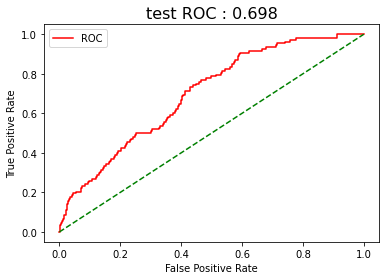

train_f1 score:  0.3452787258248009
test_f1 score:  0.14168039538714994 

train_recall score:  0.9743178170144462
test_recall score:  0.39814814814814814 

train_pre score:  0.20981679917041135
test_pre score:  0.08617234468937876 

train acc score:  0.6734288551567599
test acc score:  0.7914331465172137 

오차행렬:
 [[1934  456]
 [  65   43]]

정확도: 0.7914
정밀도: 0.0862
재현율: 0.3981
F1: 0.1417
AUC: 0.6037


In [26]:
from lightgbm import LGBMClassifier
import os
import time

start_time=time.time()

model = LGBMClassifier(
                       scale_pos_weight=20,
                       learning_rate=0.1, 
                       num_iterations = 1000, # n_estimator 랑 같은 것 같음
                       max_depth =4,
                       n_jobs=30,
                       boost_from_average=False)

trained_model = model.fit( trainX, trainY, 
          eval_set=[(testX,testY)],
          early_stopping_rounds=30, 
          verbose = 5, 
          eval_metric = 'auc')

train_pred_20 = trained_model.predict(trainX)
train_prob_20 = trained_model.predict_proba(trainX)[:, 1]

test_pred_20 = trained_model.predict(testX)
test_prob_20 = trained_model.predict_proba(testX)[:, 1]

plot_roc_curve(trainY, testY, train_pred_20, test_pred_20, train_prob_20, test_prob_20)
get_clf_eval(testY, test_pred_20)


In [24]:
pd.DataFrame(testY).value_counts()

0    2390
1     108
dtype: int64

In [99]:
TP=[]
FP=[]
TN=[]
FN=[]
for prob, pred, label in zip(test_prob_20, test_pred_20, testY):
    if pred == 1 and label ==1:
        TP.append(prob)
    elif pred == 0 and label ==1:
        FP.append(prob)
    elif pred == 0 and label ==0:
        TN.append(prob)
    elif pred == 1 and label ==0:
        FN.append(prob)

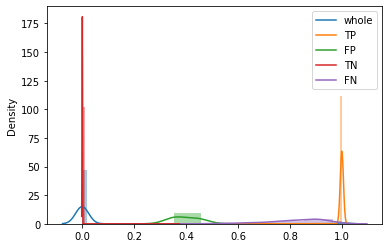

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
# fig = plt.figure(figsize(10,10))

sns.distplot(test_prob_20)
sns.distplot(TP)
sns.distplot(FP)
sns.distplot(TN)
sns.distplot(FN)
plt.legend(labels = ['whole', 'TP', 'FP', 'TN','FN'])

In [101]:
len(np.array(test_prob_20))

56060

In [102]:
sum(np.array(TP)>0.8)

2896

In [103]:
sum(np.array(FN)>0.8)

55